<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/tps/1c2024/Practica_11_completa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clase 10: Modelos de Regresión

En esta clase vamos a ver cómo cargar nuevos modelos de regresión en Bambi para luego evaluarlos y seleccionar el más apropiado.

Empecemos importando las liberías necesarias.

In [ ]:
# Instalación e import de Bambi
try:
  import bambi as bmb
except:
  !pip install bambi
  import bambi as bmb

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pandas as pd
import io

## Ejercicio 1: Modelado de variables de respuesta categóricas

Para este ejercicio vamos a utilizar el archivo **concrete_test.csv** que contiene distintos ensayos de hormigón y su composición.


### Carga de Datos

In [ ]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
from google.colab import files
uploaded = files.upload()

Saving Metro_Interstate_Traffic_Volume.xlsx to Metro_Interstate_Traffic_Volume.xlsx


In [ ]:
#Se crea un DataFrame
df_hormigon = pd.read_csv(io.BytesIO(uploaded['concrete_tests.csv']))
df_hormigon.head()

KeyError: 'concrete_tests.csv'

In [ ]:
# Vemos el tipo de dato y si existen nulos
df_hormigon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Cement                              103 non-null    float64
 1   Slag                                103 non-null    float64
 2   Fly ash                             103 non-null    float64
 3   Water                               103 non-null    float64
 4   SP                                  103 non-null    float64
 5   Coarse Aggr.                        103 non-null    float64
 6   Fine Aggr.                          103 non-null    float64
 7   SLUMP(cm)                           103 non-null    float64
 8   FLOW(cm)                            103 non-null    float64
 9   Compressive Strength (28-day)(Mpa)  103 non-null    float64
dtypes: float64(10)
memory usage: 8.2 KB


In [ ]:
df_hormigon.rename(columns={
  'Fly ash': "Fly_ash",
  'SP': "Superplasticizer",
  'Coarse Aggr.': "Coarse_aggr",
  'Fine Aggr.': "Fine_aggr",
  'SLUMP(cm)': 'Slump_cm',
  'FLOW(cm)': 'Flow_cm',
  'Compressive Strength (28-day)(Mpa)': "CompressiveStrength"
                     },
            inplace=True)

Si bien el dataset contiene variables cuantificables, vamos a llevar a cabo modelos donde nuestra **variable de respuesta es categórica**, pero el abordaje será distinto dependiendo del problema.

### Modelo 1: Regresión logística

Supongamos la siguiente situación: en vez de tener la columna **CompressiveStrength**, tenemos **Strength_Category** con una variable categórica binaria: **<40MPa** y **>=40MPa**. Nuestro objetivo será predecir si nuestro hormigón es de alta resistencia o no.

In [ ]:
df_hormigon.loc[df_hormigon['CompressiveStrength'] < 40, 'Strength_Category'] = "<40MPa"
df_hormigon.loc[df_hormigon['CompressiveStrength'] >= 40, 'Strength_Category'] = ">=40MPa"

# Transformamos en categórica
df_hormigon['Strength_Category'] = df_hormigon['Strength_Category'].astype('category')

# No utilizamos la columna de resistencia:
df_1 = df_hormigon[['Cement', 'Slag', 'Fly_ash', 'Water', 'Superplasticizer', 'Coarse_aggr', 'Fine_aggr', 'Slump_cm', 'Flow_cm', 'Strength_Category']]
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Cement             103 non-null    float64 
 1   Slag               103 non-null    float64 
 2   Fly_ash            103 non-null    float64 
 3   Water              103 non-null    float64 
 4   Superplasticizer   103 non-null    float64 
 5   Coarse_aggr        103 non-null    float64 
 6   Fine_aggr          103 non-null    float64 
 7   Slump_cm           103 non-null    float64 
 8   Flow_cm            103 non-null    float64 
 9   Strength_Category  103 non-null    category
dtypes: category(1), float64(9)
memory usage: 7.6 KB


#### EDA

Realicemos algunas visualizaciones para decidir qué variables son posibles predictores para establecer la categoría de resistencia del hormigón:

<Axes: >

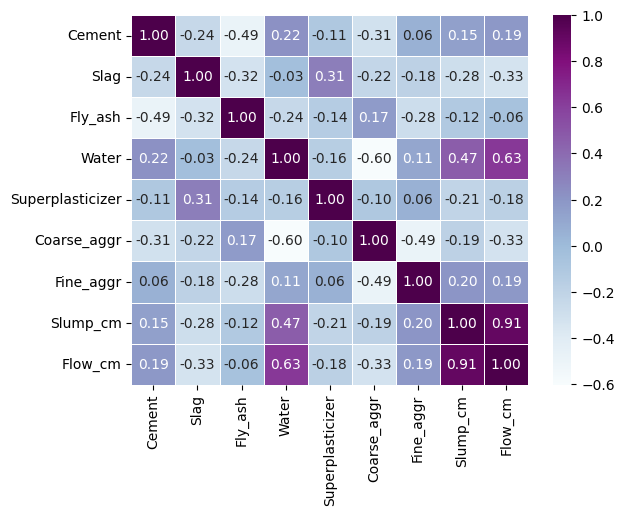

In [ ]:
features = ['Cement', 'Slag', 'Fly_ash', 'Water', 'Superplasticizer', 'Coarse_aggr', 'Fine_aggr', 'Slump_cm', 'Flow_cm']

# Gráfico de calor para la matriz de correlación
sns.heatmap(df_1[features].corr(), cmap='BuPu', fmt='.2f', annot=True, linewidths=.6)

Note que si bien los gráficos de punto pueden ser muy útiles, a veces los histogramas y los gráficos de caja son más fáciles de visualizar y comprender

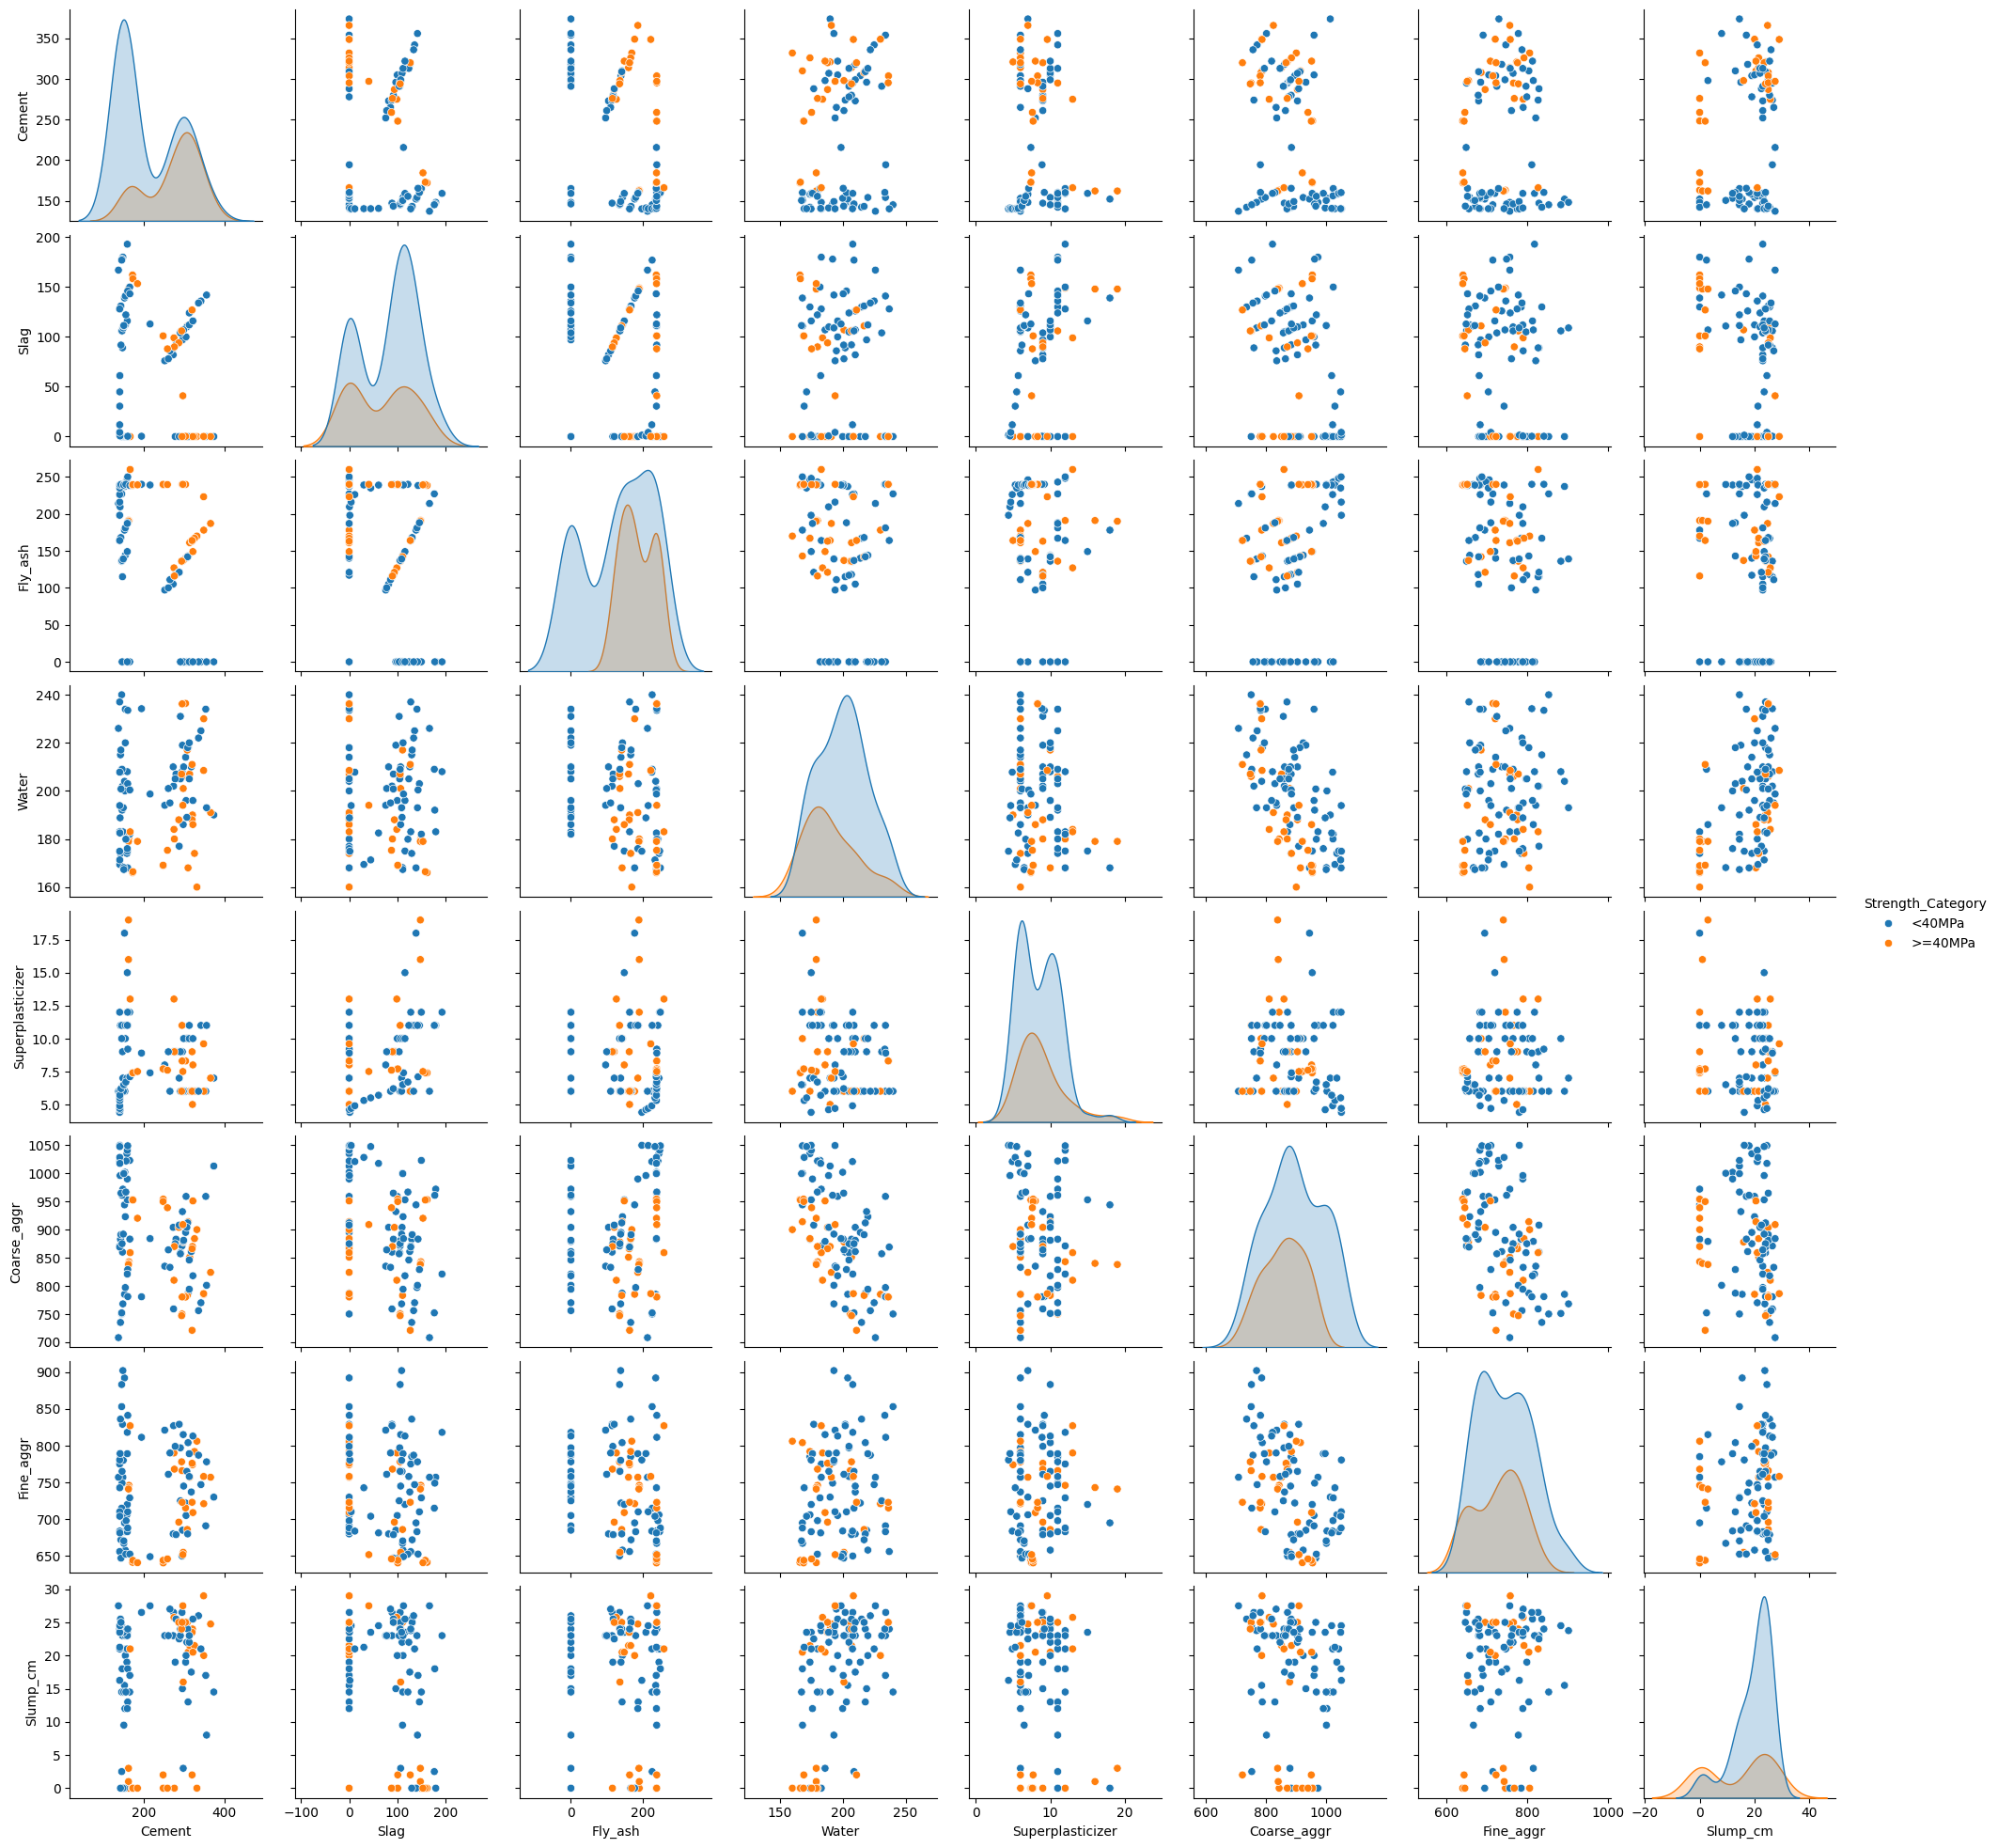

In [ ]:
features = ['Cement', 'Slag', 'Fly_ash', 'Water', 'Superplasticizer', 'Coarse_aggr', 'Fine_aggr', 'Slump_cm', 'Strength_Category']

# Grilla de gráficos de puntos
sns.pairplot(df_1[features], hue='Strength_Category')

Algunas alternativas donde podemos ver más claramente cada categoría:

[Text(0.5, 1.0, 'Asentamiento'),
 Text(0.5, 0, 'Categoría'),
 Text(0, 0.5, 'Asentamiento')]

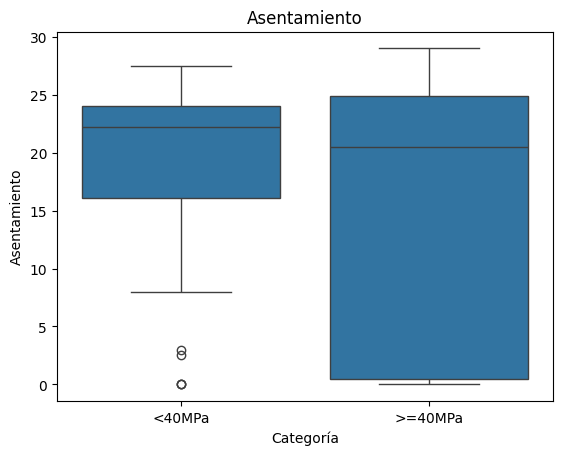

In [ ]:
sns.boxplot(y='Slump_cm', x='Strength_Category', data=df_1).set(
    title = 'Asentamiento', xlabel='Categoría', ylabel='Asentamiento')

[Text(0.5, 1.0, 'Asentamiento'),
 Text(0.5, 0, 'Categoría'),
 Text(0, 0.5, 'Asentamiento')]

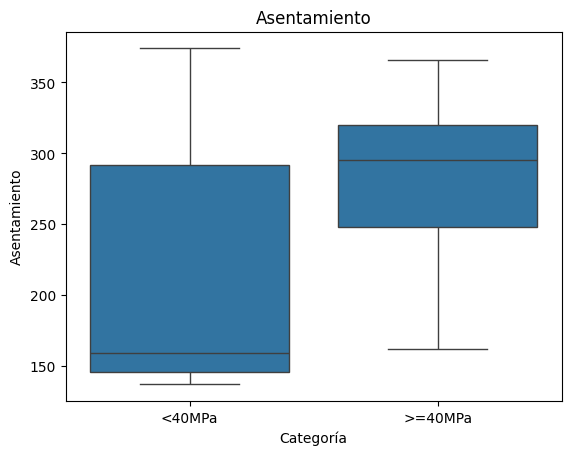

In [ ]:
sns.boxplot(y='Cement', x='Strength_Category', data=df_1).set(
    title = 'Asentamiento', xlabel='Categoría', ylabel='Asentamiento')

[Text(0.5, 1.0, 'Humo de Sílice'),
 Text(0.5, 0, 'Categoría'),
 Text(0, 0.5, 'Humo de Sílice')]

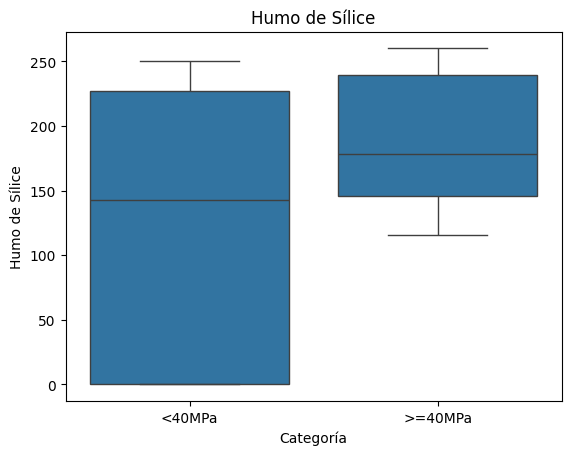

In [ ]:
sns.boxplot(y='Fly_ash', x='Strength_Category', data=df_1).set(
    title = 'Humo de Sílice', xlabel='Categoría', ylabel='Humo de Sílice')

[Text(0.5, 1.0, 'Agua'), Text(0.5, 0, 'Categoría'), Text(0, 0.5, 'Agua')]

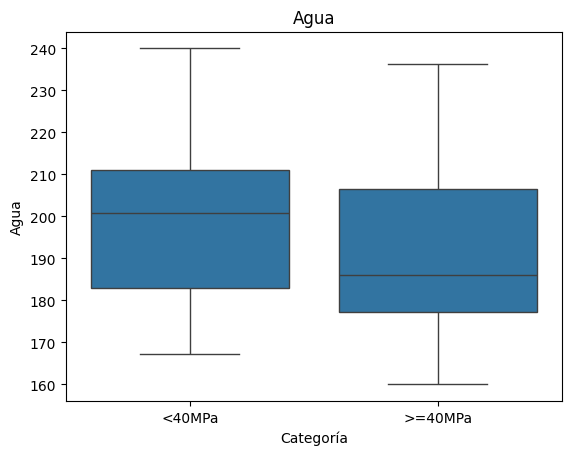

In [ ]:
sns.boxplot(y='Water', x='Strength_Category', data=df_1).set(
    title = 'Agua', xlabel='Categoría', ylabel='Agua')

[Text(0.5, 1.0, 'Resistencia y Asentamiento'),
 Text(0.5, 0, 'Categoría'),
 Text(0, 0.5, 'Asentamiento')]

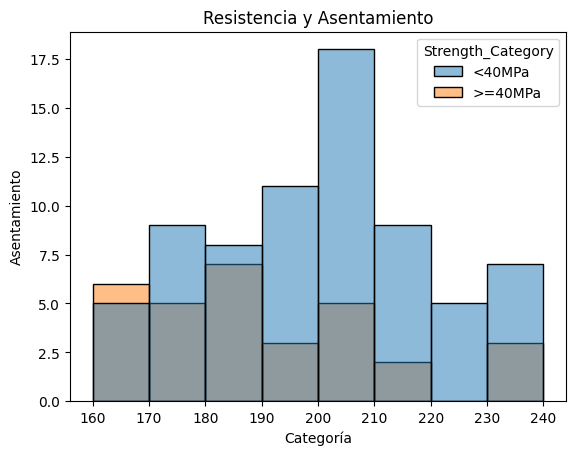

In [ ]:
sns.histplot(data=df_1, x='Water', hue='Strength_Category').set(
    title = 'Resistencia y Asentamiento', xlabel='Categoría', ylabel='Asentamiento')

Veamos un poco los datos: recuerde que si los rangos de las distintas variables son muy diversas, es recomendable estandarizar para facilitar la convergencia:

In [ ]:
df_1.describe()

,Cement,Slag,Fly_ash,Water,Superplasticizer,Coarse_aggr,Fine_aggr,Slump_cm,Flow_cm
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.00000
mean,229.894175,77.973786,149.014563,197.167961,8.539806,883.978641,739.604854,18.048544,49.61068
std,78.877230,60.461363,85.418080,20.208158,2.807530,88.391393,63.342117,8.750844,17.56861
min,137.000000,0.000000,0.000000,160.000000,4.400000,708.000000,640.600000,0.000000,20.00000
25%,152.000000,0.050000,115.500000,180.000000,6.000000,819.500000,684.500000,14.500000,38.50000
50%,248.000000,100.000000,164.000000,196.000000,8.000000,879.000000,742.700000,21.500000,54.00000
75%,303.900000,125.000000,235.950000,209.500000,10.000000,952.800000,788.000000,24.000000,63.75000
max,374.000000,193.000000,260.000000,240.000000,19.000000,1049.900000,902.000000,29.000000,78.00000


Las variables que utilizaremos son:

In [ ]:
features = ['Cement', 'Fly_ash', 'Slump_cm', 'Water']

#### Modelado


Nuestro objetivo final es, utilizando nuestro entendimiento del problema, modelar Y con uno o más de los predictores anteriores.

De manera similar a como hicimos en clases anteriores, tenemos que indicarle a bambi:
- las priors,
- el DataFrame con los datos,
- la familia: **Bernoulli** ya que Y es un indicador binario de algún evento de interés que ocurre con una cierta probabilidad
- la fórmula: en el lado izquierdo, indicamos que queremos conocer la probabilidad de que **Strength_Category** es **'>=40MPa'**, mientras que en el lado derecho, indicamos las variables explicativas del modelo y sus interacciones:

In [ ]:
model_1 = bmb.Model("Strength_Category['>=40MPa'] ~ Cement + Fly_ash + Slump_cm", df_1, family="bernoulli")
fitted_1 = model_1.fit(draws=4000, chains=2, target_accept=0.85, idata_kwargs={"log_likelihood": True})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-15.893,3.116,-21.721,-10.107,0.061,0.044,2653.0,2982.0,1.0
Cement,0.047,0.009,0.030,0.064,0.000,0.000,2697.0,2969.0,1.0
Fly_ash,0.041,0.009,0.025,0.058,0.000,0.000,2690.0,2996.0,1.0
Slump_cm,-0.165,0.047,-0.254,-0.077,0.001,0.001,4014.0,4019.0,1.0


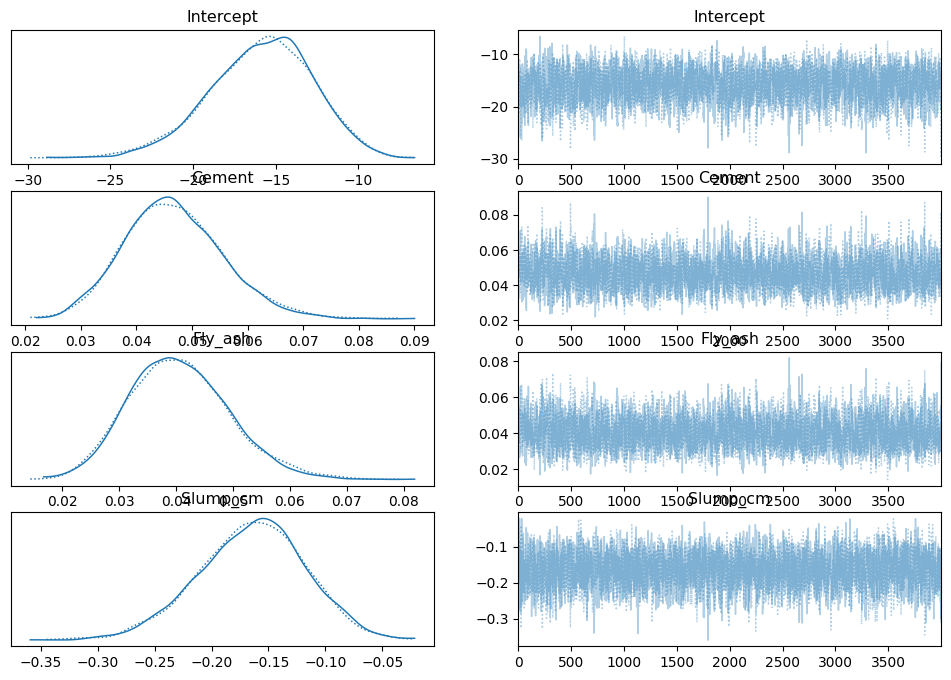

In [ ]:
az.plot_trace(fitted_1);
az.summary(fitted_1)

Probemos otros modelos, por ejemplo agregando una variable explicativa

In [ ]:
model_2 = bmb.Model("Strength_Category['>=40MPa'] ~ Cement + Fly_ash + Water + Slump_cm", df_1, family="bernoulli")
fitted_2 = model_2.fit(draws=4000, chains=2, target_accept=0.85, idata_kwargs={"log_likelihood": True})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-8.745,4.572,-17.107,-0.107,0.062,0.046,5607.0,5440.0,1.0
Cement,0.053,0.010,0.034,0.073,0.000,0.000,2278.0,3415.0,1.0
Fly_ash,0.043,0.009,0.026,0.061,0.000,0.000,2375.0,3387.0,1.0
Water,-0.049,0.025,-0.098,-0.003,0.000,0.000,4486.0,4314.0,1.0
Slump_cm,-0.142,0.051,-0.237,-0.049,0.001,0.001,4110.0,4702.0,1.0


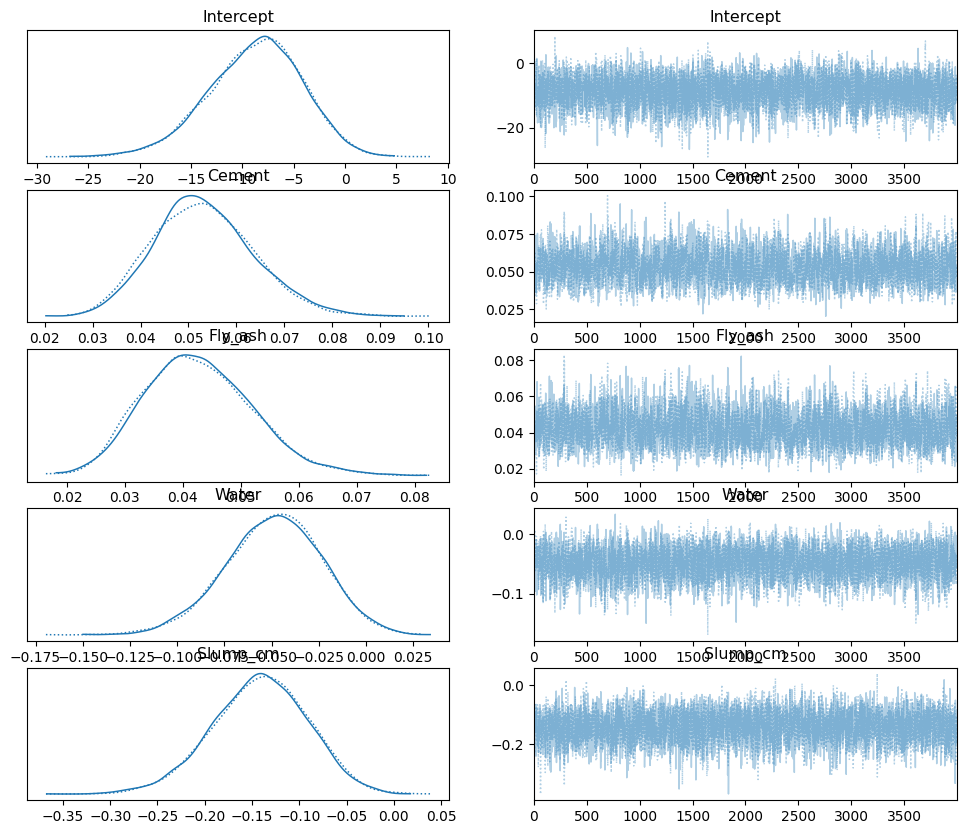

In [ ]:
az.plot_trace(fitted_2);
az.summary(fitted_2)

O podemos agregar una relación entre ellas, como por ejemplo, la proporción agua cemento de la siguiente forma:

```
model_3 = bmb.Model("Strength_Category['>=40MPa'] ~ Cement + Fly_ash + Water + Slump_cm + I(Water / Cement)", df_1, family="bernoulli")
```
Dado que al final quisiera visualizar un gráfico de bosque con la variable, voy a modificarel DataFrame, creando una nueva columna:


In [ ]:
df_1["Water_Cement_Ratio"] = df_1["Water"] / df_1["Cement"]

In [ ]:
model_3 = bmb.Model("Strength_Category['>=40MPa'] ~ Cement + Fly_ash + Water + Slump_cm + Water_Cement_Ratio", df_1, family="bernoulli")
fitted_3 = model_3.fit(draws=4000, chains=2, target_accept=0.85, idata_kwargs={"log_likelihood": True})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.151,7.143,-11.268,15.566,0.092,0.070,6016.0,5818.0,1.0
Cement,0.019,0.019,-0.016,0.054,0.000,0.000,3907.0,4399.0,1.0
Fly_ash,0.044,0.010,0.027,0.063,0.000,0.000,3744.0,4336.0,1.0
Water,-0.015,0.031,-0.075,0.043,0.000,0.000,4770.0,4607.0,1.0
Slump_cm,-0.163,0.057,-0.270,-0.058,0.001,0.001,4813.0,5504.0,1.0
Water_Cement_Ratio,-10.409,4.977,-19.548,-0.989,0.076,0.053,4337.0,4838.0,1.0


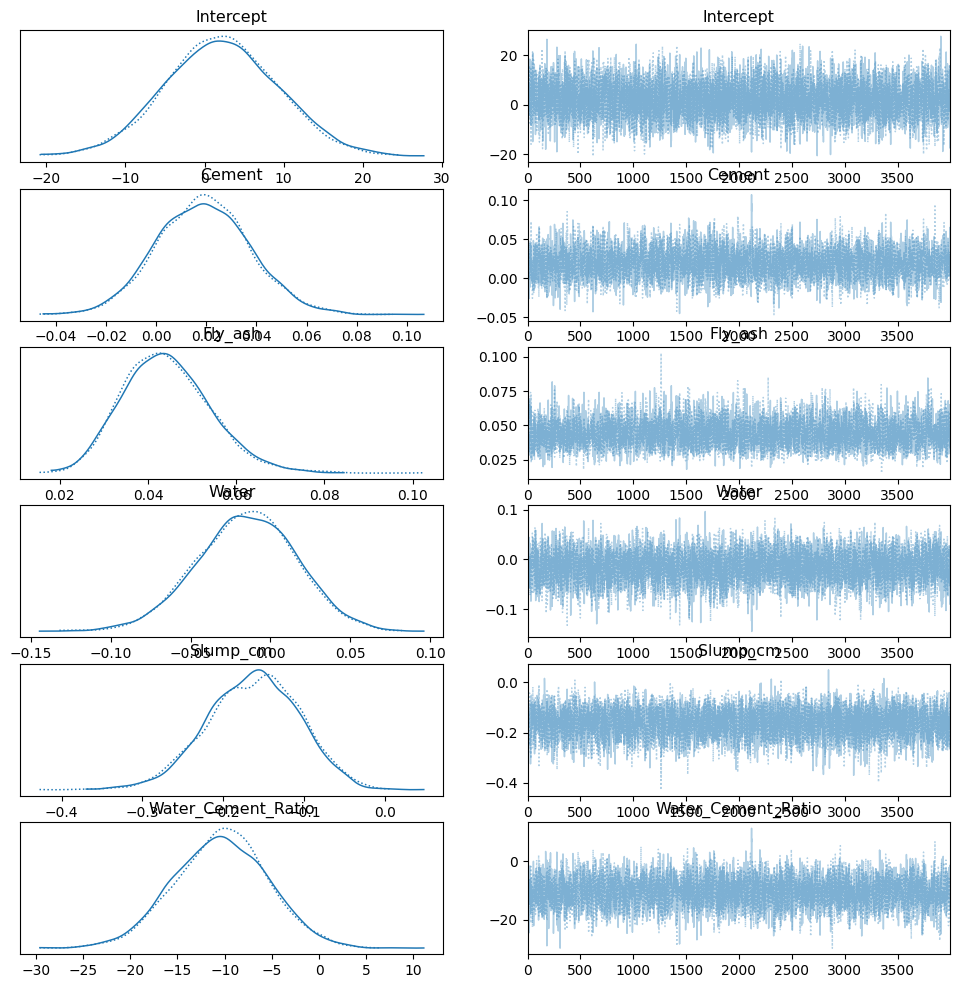

In [ ]:
az.plot_trace(fitted_3);
az.summary(fitted_3)

In [ ]:
model_4 = bmb.Model("Strength_Category['>=40MPa'] ~ Fly_ash + Slump_cm + Water_Cement_Ratio", df_1, family="bernoulli")
fitted_4 = model_4.fit(draws=4000, chains=2, target_accept=0.85, idata_kwargs={"log_likelihood": True})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,7.600,2.150,3.742,11.691,0.039,0.028,3126.0,4316.0,1.0
Fly_ash,0.040,0.009,0.023,0.055,0.000,0.000,2294.0,3433.0,1.0
Slump_cm,-0.151,0.050,-0.247,-0.063,0.001,0.001,2922.0,3899.0,1.0
Water_Cement_Ratio,-14.214,2.814,-19.356,-8.888,0.062,0.044,2061.0,2932.0,1.0


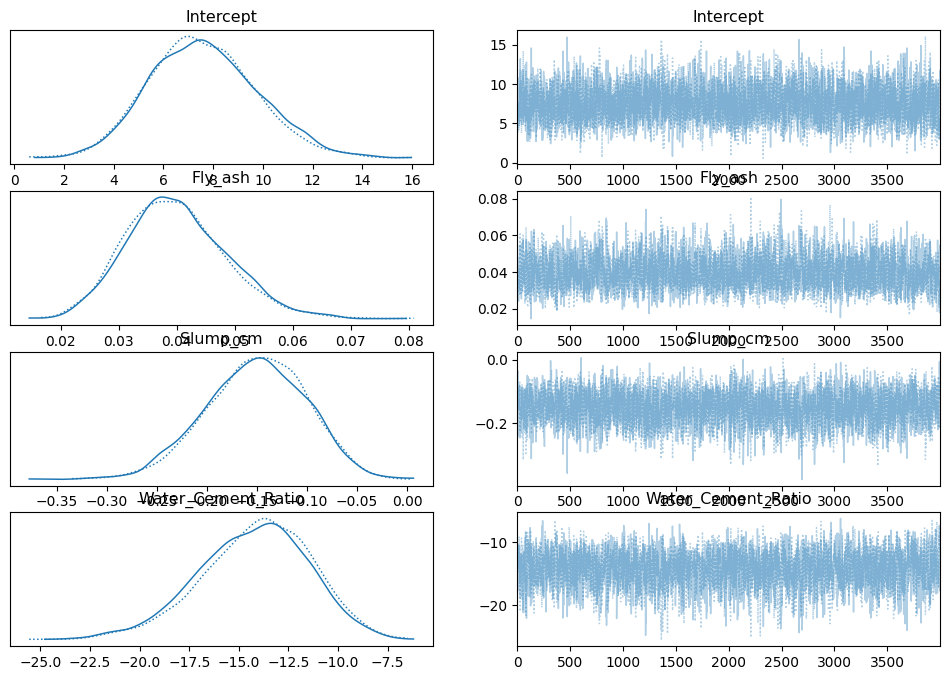

In [ ]:
az.plot_trace(fitted_4);
az.summary(fitted_4)

Comparando los modelos:

In [ ]:
models_dict = {
    "model_1": fitted_1,
    "model_2": fitted_2,
    "model_3": fitted_3,
    "model_4": fitted_4
}
df_compare = az.compare(models_dict)
df_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_4,0,-23.953064,2.796026,0.000000,1.000000e+00,4.041247,0.000000,False,log
model_3,1,-25.491298,4.227178,1.538234,4.440892e-16,4.504807,0.665415,False,log
model_2,2,-26.930993,4.029120,2.977929,0.000000e+00,4.547341,1.182650,False,log
model_1,3,-28.191468,3.170774,4.238404,0.000000e+00,5.053482,2.240470,False,log


Note que p_loo se corresponde con el número de parámetros del modelo y elpd_diff es reducida.

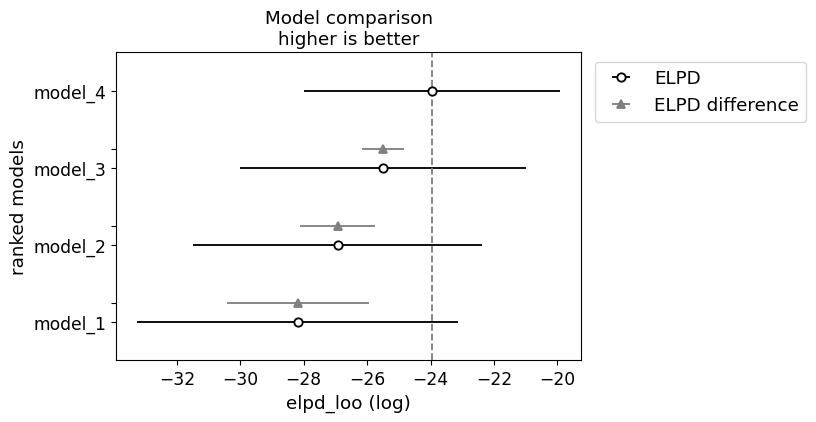

In [ ]:
az.plot_compare(df_compare, insample_dev=False);

Existe una diferencia en las estimaciones puntuales (círculos vacíos) entre el modelo con las 4 variables y la interrelación (modelo 3) y el modelo con las 4 variables (modelo 2). Note además, que existe superposición entre sus estimaciones de intervalo.

Teniendo en cuenta lo anterior, **¿qué modelo seleccionaría?**

Analicemos las variables utilizadas:

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

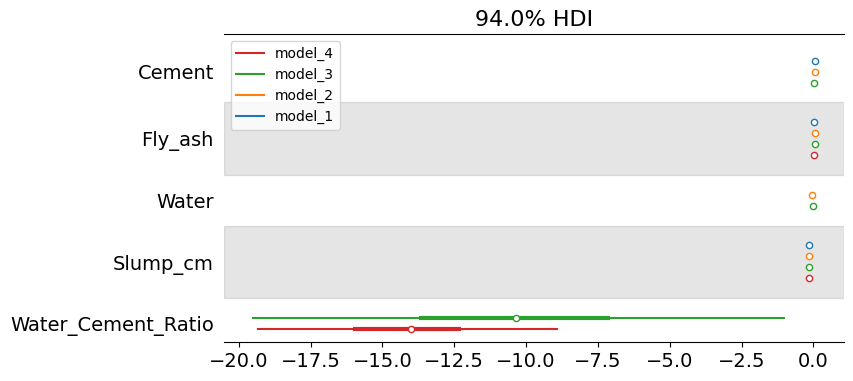

In [ ]:
az.plot_forest(
    [fitted_1, fitted_2, fitted_3, fitted_4],
    model_names=["model_1", "model_2", "model_3", "model_4"],
    var_names=["Cement", "Fly_ash", "Water" , "Slump_cm", "Water_Cement_Ratio"],
    combined=True,
    figsize=(8, 4)
)

Si miramos con detalle sobre el cero:

(-0.35, 0.2)

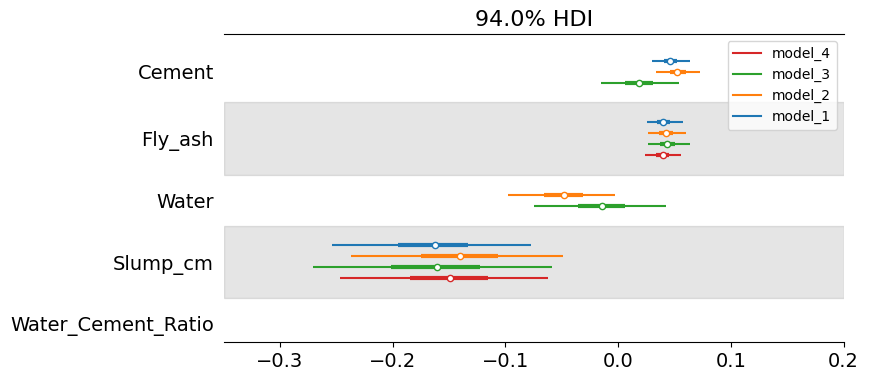

In [ ]:
az.plot_forest(
    [fitted_1, fitted_2, fitted_3, fitted_4],
    model_names=["model_1", "model_2", "model_3", "model_4"],
    var_names=["Cement", "Fly_ash", "Water" , "Slump_cm", "Water_Cement_Ratio"],
    combined=True,
    figsize=(8, 4)
);

#Ajustamos para ver los valores sobre el cero que parecen puntos...
plt.xlim(-0.35, 0.20)

### Modelo 2: Regresión categórica (no binaria)



Hasta el momento vimos cómo modelar resultados binarios con Bambi, donde se utiliza la familia **Bernoulli**, pero en caso de querer hacerlo con un número arbitrario de resultados, la multivariada de la familia Bernoulli es la familia **categórica**.

Supongamos que tenemos las mismas variables: composición del hormigón y resultados de ensayo, pero además poseemos tres tipos de hormigón:
- hormigón convencional: HC
- hormigón liviano: con poliestireno expandido: HL1
- hormigón liviano: con leca o arcilla expandida: HL2

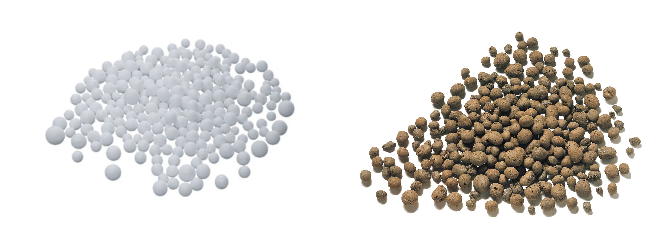

El modelo se define de manera muy similar a lo anterior:



```
# Modelo 2:
model_2 = bmb.Model('Concrete_category ~ CompressiveStrength', data, family="categorical", priors=priors)
```



### Modelo 3: Regresión ordinal

Otra situación que podría presentarse es modelizar Y, que se trata de un conjunto de categorías ordenadas. En este caso, si bien nos hacemos una idea de qué categoría es mayor a otra, no podemos establecer la diferencia entre ellas, de hecho, no necesariamente deben ser equidistantes.

Supongamos que ahora, en vez de la columna con el extendido y el asentamiento, tenemos una variable categórica con la consistencia del hormigón, resultando 5 categorías según la normativa nacional:
- Seca: un asentamiento menor a 4cm.
- Plástica: entre 5 y 9cm.
- Blanda: entre 10 y 15cm.
- Fluída:entre 16 y 21cm.
- Líquida: un asentamiento mayor a 24cm

In [ ]:
df_hormigon.loc[df_hormigon['Slump_cm'] <= 4, 'Consistency'] = "Seca"
df_hormigon.loc[(df_hormigon['Slump_cm'] > 5) & (df_hormigon['Slump_cm'] <= 9), 'Consistency'] = "Plástica"
df_hormigon.loc[(df_hormigon['Slump_cm'] > 10) & (df_hormigon['Slump_cm'] <= 15), 'Consistency'] = "Blanda"
df_hormigon.loc[(df_hormigon['Slump_cm'] > 16) & (df_hormigon['Slump_cm'] <= 21), 'Consistency'] = "Fluída"
df_hormigon.loc[df_hormigon['Slump_cm'] >= 24, 'Consistency'] = "Líquida"

A la columna `Consistency` la transformamos en tipo categórica e indicamos el orden de las mismas en `categories` e indicando `ordered=True`



In [ ]:
df_hormigon['Consistency'] = pd.Categorical(df_hormigon['Consistency'], categories=["Seca", "Plástica", "Blanda", "Fluída", "Líquida"], ordered=True)
df_hormigon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Cement               103 non-null    float64 
 1   Slag                 103 non-null    float64 
 2   Fly_ash              103 non-null    float64 
 3   Water                103 non-null    float64 
 4   Superplasticizer     103 non-null    float64 
 5   Coarse_aggr          103 non-null    float64 
 6   Fine_aggr            103 non-null    float64 
 7   Slump_cm             103 non-null    float64 
 8   Flow_cm              103 non-null    float64 
 9   CompressiveStrength  103 non-null    float64 
 10  Strength_Category    103 non-null    category
 11  Consistency          79 non-null     category
dtypes: category(2), float64(10)
memory usage: 8.7 KB


El modelo se define de manera muy similar a lo anterior, salvo que cambian las familias:
- `family = "cumulative"` si es acumulativo
- `family = "sratio"` si es secuencial.

## Ejercicio 2: Conteo de eventos
Para este ejercicio vamos a utilizar el archivo **Metro_Interstate_Traffic_Volume.csv** que contiene un volumen de tráfico interestatal metropolitano por hora entre Minneapolis y St Paul, MN para la I-94 en dirección oeste. Además, incluye las condiciones meteorológicas y festivas de 2012 a 2018.


### Carga de Datos

In [ ]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
from google.colab import files
uploaded = files.upload()

Saving Metro_Interstate_Traffic_Volume.xlsx to Metro_Interstate_Traffic_Volume (1).xlsx


In [ ]:
#Se crea un DataFrame
df= pd.read_excel(io.BytesIO(uploaded['Metro_Interstate_Traffic_Volume.xlsx']))
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              61 non-null     object        
 1   temp                 48204 non-null  float64       
 2   rain_1h              48204 non-null  float64       
 3   snow_1h              48204 non-null  float64       
 4   clouds_all           48204 non-null  int64         
 5   weather_main         48204 non-null  object        
 6   weather_description  48204 non-null  object        
 7   date_time            48204 non-null  datetime64[ns]
 8   traffic_volume       48204 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 3.3+ MB


In [ ]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,date_time,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,2016-01-05 10:46:16.773711616,3259.818355
min,0.000000,0.000000,0.000000,0.000000,2012-10-02 09:00:00,0.000000
25%,272.160000,0.000000,0.000000,1.000000,2014-02-06 11:45:00,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,2016-06-11 03:30:00,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,2017-08-11 06:00:00,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,2018-09-30 23:00:00,7280.000000
std,13.338232,44.789133,0.008168,39.015750,NaN,1986.860670


Perfecto, todo checkeado, pero... **¿Qué es lo que nos interesa analizar?** Queremos ver el volumen de tránsito a la hora pico, asi que... ¡manos a la obra con la limpieza!

### EDA

Vamos a analizar las columnas con más detalle. Por ejemplo, la columna `holiday`:

In [ ]:
df['holiday'].unique()

array([nan, 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

**¿Vale la pena analizar los dias festivos junto a los no festivos? ¿Y qué ocurre con los días no laborales?** Lo cierto es que tenemos que definir muestras hipótesis en función a lo que queremos analizar. Por eso, para mi sería mejor analizar unicamente los dias de semana, no feriados, que es donde el flujo vehicular es mayor:

In [ ]:
# Me quedo con los valores donde holiday es null, es decir, no hay festividad
df = df[df['holiday'].isnull()]
df.shape

(48143, 9)

Antes tenia 48204 filas, así que vamos bien. Ahora excluyamos los fin de semana:

In [ ]:
# Creo una columna con el día de la semana
df['day'] = df['date_time'].dt.dayofweek

# Excluyo los fines de semana
df = df[(df['day'] != 5) & (df['day'] != 6)]
df['day'].unique()

<ipython-input-12-25f5a2ce3ae1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df['date_time'].dt.dayofweek


array([1, 2, 3, 4, 0], dtype=int32)

Ahora, vamos a ver cuál es la hora pico:

In [ ]:
# Creo una columna con la hora de los registros.
df['hour'] = df['date_time'].dt.hour

# Calculo la media horaria y ordeno los valores
df.groupby(['hour'])['traffic_volume'].mean().sort_values(ascending=False)

hour
16    6189.473647
7     6030.413559
17    5784.827133
15    5592.897768
8     5503.497970
6     5365.983210
14    5152.995778
9     4895.269257
13    4859.180473
12    4855.382143
11    4633.419470
18    4434.209431
10    4378.419118
19    3298.340426
20    2842.433004
5     2701.296703
21    2673.042807
22    2125.913104
23    1379.549728
4      832.661096
0      642.248222
1      396.913043
3      362.289835
2      301.982818
Name: traffic_volume, dtype: float64

Ya sabemos nuestra hora a analizar: **16:00**, asi que genero mi nuevo DataFrame:

<Axes: xlabel='traffic_volume', ylabel='Count'>

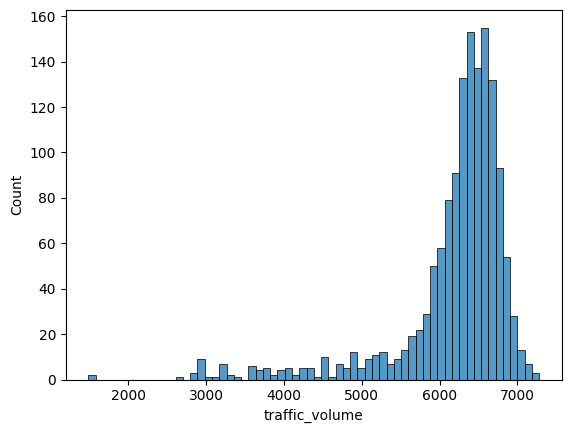

In [ ]:
# Me quedo con la hora pico
df_peak = df[df['hour'] == 16]

sns.histplot(data = df_peak, x = "traffic_volume")

Otras modificaciones que podríamos hacer con los datos, es por ejemplo, cambiar las unidades de la columna con temperatura en K.

In [ ]:
# Paso a °C
df_peak['temp'] = df_peak['temp'] - 273

<ipython-input-15-d3b5196856cd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_peak['temp'] = df_peak['temp'] - 273


Veamos la correlación evitar seleccionar variables que nos brinden la misma información:

<Axes: >

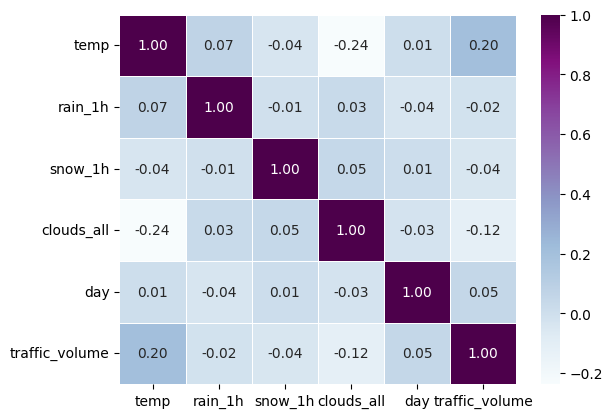

In [ ]:
features = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'day', 'traffic_volume']

# Gráfico de calor para la matriz de correlación
sns.heatmap(df_peak[features].corr(), cmap='BuPu', fmt='.2f', annot=True, linewidths=.6)

### Modelo

En este caso, queremos contruir un modelo de regresión en el que la variable de respuesta representa un recuento de eventos discretos que ocurren en un intervalo fijo de espacio o tiempo: flujo de tránsito en un lugar y horario determinado.

Para ello, vamos a considerar diversos factores, como puede ser las condiciones de la carretera y el clima, entre otros.

In [ ]:
# Definir el modelo de binomial negativa
model_1 = bmb.Model('traffic_volume ~ day', df_peak, family='negativebinomial')
fitted_1 = model_1.fit(draws=4000, chains=2, target_accept=0.85, idata_kwargs={"log_likelihood": True})

In [ ]:
# Resumen de la inferencia
az.summary(fitted_1)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,8.722,0.006,8.710,8.735,0.000,0.000,11356.0,6439.0,1.0
day,0.004,0.003,-0.001,0.010,0.000,0.000,11276.0,6226.0,1.0
traffic_volume_alpha,51.289,1.936,47.580,54.893,0.018,0.013,11159.0,5982.0,1.0


In [ ]:
# Definir el modelo de binomial negativa
model_2 = bmb.Model('traffic_volume ~ day + clouds_all', df_peak, family='negativebinomial')
fitted_2 = model_2.fit(draws=4000, chains=2, target_accept=0.85, idata_kwargs={"log_likelihood": True})

In [ ]:
# Resumen de la inferencia
az.summary(fitted_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,8.743,0.008,8.727,8.759,0.000,0.000,9671.0,6487.0,1.0
day,0.004,0.003,-0.001,0.009,0.000,0.000,11814.0,6524.0,1.0
clouds_all,-0.000,0.000,-0.001,-0.000,0.000,0.000,8759.0,5871.0,1.0
traffic_volume_alpha,51.758,2.001,48.015,55.474,0.021,0.015,9444.0,6562.0,1.0


In [ ]:
# Definir el modelo de binomial negativa
model_3 = bmb.Model('traffic_volume ~ day + clouds_all + temp', df_peak, family='negativebinomial')
fitted_3 = model_3.fit(draws=4000, chains=2, target_accept=0.85, idata_kwargs={"log_likelihood": True})

In [ ]:
# Resumen de la inferencia
az.summary(fitted_3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,8.715,0.010,8.697,8.733,0.00,0.000,8444.0,6173.0,1.0
day,0.004,0.003,-0.001,0.009,0.00,0.000,10287.0,6509.0,1.0
clouds_all,-0.000,0.000,-0.000,-0.000,0.00,0.000,9405.0,6830.0,1.0
temp,0.002,0.000,0.001,0.002,0.00,0.000,8137.0,6267.0,1.0
traffic_volume_alpha,53.113,1.985,49.354,56.715,0.02,0.014,9526.0,6532.0,1.0


Otra opción es utilizar la columna `weather_main`:

In [ ]:
df_peak["weather_main"].value_counts()

weather_main
Clouds          608
Clear           323
Rain            180
Mist             96
Snow             79
Drizzle          52
Haze             44
Thunderstorm     27
Fog              12
Smoke             2
Name: count, dtype: int64

**¿La visibilidad puede hacer que las personas decidan cambiar su modo de transporte?**

In [ ]:
# Applying the condition
df_peak.loc[df_peak["weather_main"] == "Fog", "visibility"] = 0
df_peak.loc[df_peak["weather_main"] == "Mist", "visibility"] = 0
df_peak.loc[df_peak["weather_main"] == "Haze", "visibility"] = 0
df_peak["visibility"] = df_peak["visibility"].fillna(1)
df_peak.head()

<ipython-input-24-2bbfa9cec30d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_peak.loc[df_peak["weather_main"] == "Fog", "visibility"] = 0
<ipython-input-24-2bbfa9cec30d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_peak["visibility"] = df_peak["visibility"].fillna(1)


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,day,hour,visibility
7,NaN,20.86,0.0,0.0,1,Clear,sky is clear,2012-10-02 16:00:00,6015,1,16,1.0
28,NaN,22.13,0.0,0.0,1,Clear,sky is clear,2012-10-03 16:00:00,6137,2,16,1.0
51,NaN,25.06,0.0,0.0,20,Clouds,few clouds,2012-10-04 16:00:00,6292,3,16,1.0
73,NaN,8.73,0.0,0.0,90,Clouds,overcast clouds,2012-10-05 16:00:00,6069,4,16,1.0
142,NaN,11.33,0.0,0.0,1,Clear,sky is clear,2012-10-08 16:00:00,5979,0,16,1.0


Para pensar, **¿Cómo agregarías estas nueva variable?**

In [ ]:
# Definir el modelo de binomial negativa
model_4 = bmb.Model('traffic_volume ~ day + clouds_all + temp + visibility', df_peak, family='negativebinomial')
fitted_4 = model_4.fit(draws=4000, chains=2, target_accept=0.85, idata_kwargs={"log_likelihood": True})

In [ ]:
# Resumen de la inferencia
az.summary(fitted_4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,8.688,0.015,8.659,8.715,0.000,0.000,9536.0,5818.0,1.0
day,0.004,0.003,-0.001,0.009,0.000,0.000,9573.0,6373.0,1.0
clouds_all,-0.000,0.000,-0.000,0.000,0.000,0.000,10091.0,6492.0,1.0
temp,0.002,0.000,0.001,0.002,0.000,0.000,10924.0,7049.0,1.0
visibility,0.029,0.012,0.005,0.051,0.000,0.000,10399.0,6585.0,1.0
traffic_volume_alpha,53.288,2.019,49.676,57.324,0.022,0.016,8376.0,5648.0,1.0


In [ ]:
models_dict = {
    "model_1": fitted_1,
    "model_2": fitted_2,
    "model_3": fitted_3,
    "model_4": fitted_4
}
df_compare = az.compare(models_dict)
df_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_4,0,-11617.834812,11.972400,0.000000,0.789699,69.850972,0.000000,False,log
model_3,1,-11619.459256,10.820336,1.624444,0.210301,69.809326,2.380082,False,log
model_2,2,-11637.384738,10.264363,19.549925,0.000000,70.124822,6.087493,False,log
model_1,3,-11643.395990,9.418013,25.561178,0.000000,70.410635,6.795815,False,log


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

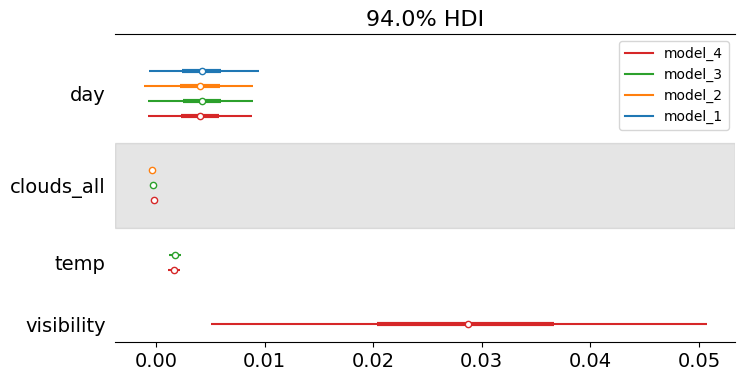

In [ ]:
az.plot_forest(
    [fitted_1, fitted_2, fitted_3, fitted_4],
    model_names=["model_1", "model_2", "model_3", "model_4"],
    var_names=["day", "clouds_all", "temp", "visibility"],
    combined=True,
    figsize=(8, 4)
)

Observando las tablas anteriores, **Qué opina de los modelos?**

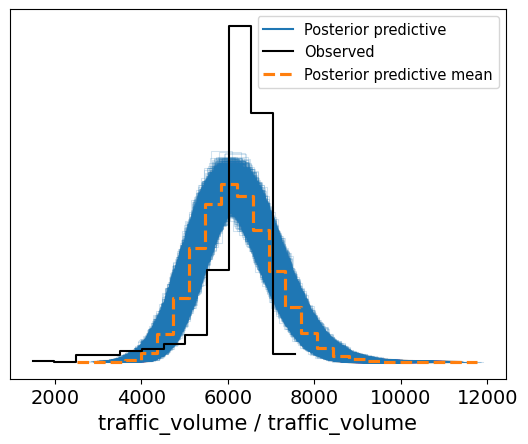

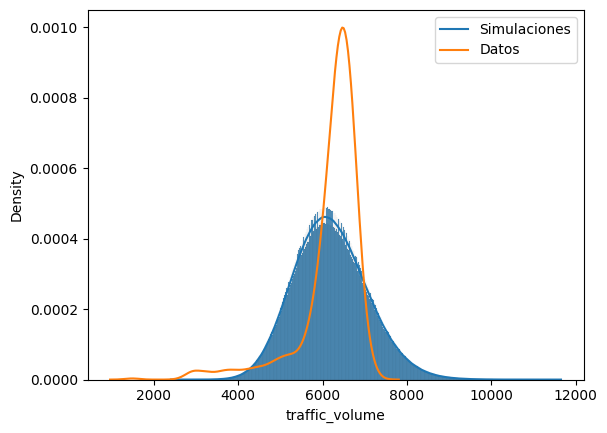

In [ ]:
# Simulaciones predictivas
model_4.predict(fitted_4, kind="pps")

# Posterior predictiva
az.plot_ppc(fitted_4)
plt.show()

# Histograma
sns.histplot(data=np.ravel(fitted_4.posterior_predictive['traffic_volume']),stat='density')
sns.kdeplot(data=np.ravel(fitted_4.posterior_predictive['traffic_volume']),label='Simulaciones')
sns.kdeplot(data = df_peak, x='traffic_volume',label='Datos')
plt.legend()
plt.show()

Otras opciones que podrían ser interesantes probar:

- Incluir la interacción entre las variables categóricas (es decir, que el efecto de la visibilidad es también función del día, por ejemplo)
- Construir un modelo multiplicativo en vez de aditivo (link=log), donde las variables categóricas explican entonces cambios relativos, estilo factores de modificación
- Modelos más complejos de generación de datos

¡Hay mucho para hacer!